In [45]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns
from sklearn.metrics import confusion_matrix
import seaborn as sns




# Read in Data
* no null values
* we have both categorical and numerical inputs

In [25]:
data = pd.read_csv('IncomePredictionTrain.txt')
data = data.drop(columns = ['rowid'])
data.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,yearly_income
0,38,Private,108907,HS-grad,9,Divorced,Craft-repair,Not-in-family,White,Male,0,0,40,?,<=50K
1,58,Self-emp-not-inc,33309,HS-grad,9,Widowed,Farming-fishing,Not-in-family,White,Male,0,0,80,United-States,<=50K
2,62,Private,169204,HS-grad,9,Widowed,Craft-repair,Unmarried,White,Male,0,0,40,United-States,<=50K
3,53,Private,82646,Doctorate,16,Divorced,Exec-managerial,Not-in-family,White,Female,0,0,55,United-States,>50K
4,40,Local-gov,233891,HS-grad,9,Never-married,Adm-clerical,Unmarried,Black,Female,0,0,35,United-States,<=50K


In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26049 entries, 0 to 26048
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             26049 non-null  int64 
 1   workclass       26049 non-null  object
 2   fnlwgt          26049 non-null  int64 
 3   education       26049 non-null  object
 4   education_num   26049 non-null  int64 
 5   marital_status  26049 non-null  object
 6   occupation      26049 non-null  object
 7   relationship    26049 non-null  object
 8   race            26049 non-null  object
 9   sex             26049 non-null  object
 10  capital_gain    26049 non-null  int64 
 11  capital_loss    26049 non-null  int64 
 12  hours_per_week  26049 non-null  int64 
 13  native_country  26049 non-null  object
 14  yearly_income   26049 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.0+ MB


# Split the data

In [27]:
target = data['yearly_income']
data = data.drop(columns = ['yearly_income'])
data_train, data_test, target_train, target_test = train_test_split(data, target, random_state=42, test_size=0.25)
data = None

In [28]:
len(data_test)

6513

In [29]:
len(data_train)

19536

# Set Up Model With Preprocessing

In [30]:

numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(data_train)
categorical_columns = categorical_columns_selector(data_train)

In [31]:
numerical_columns

['age',
 'fnlwgt',
 'education_num',
 'capital_gain',
 'capital_loss',
 'hours_per_week']

In [32]:
data_train[numerical_columns].describe()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
count,19536.000000,1.953600e+04,19536.000000,19536.000000,19536.000000,19536.000000
mean,38.550164,1.888322e+05,10.077805,1043.222256,85.307279,40.383600
std,13.611143,1.046357e+05,2.582568,7166.948899,398.617120,12.525388
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.173810e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.779035e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.358940e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [33]:
categorical_columns

['workclass',
 'education',
 'marital_status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native_country']

In [34]:
data_train[categorical_columns].describe()

,workclass,education,marital_status,occupation,relationship,race,sex,native_country
count,19536,19536,19536,19536,19536,19536,19536,19536
unique,9,16,7,15,6,5,2,41
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States
freq,13650,6268,8972,2498,7887,16700,13037,17487


In [35]:
# education is the same as education number so drop education
data_train = data_train.drop(columns = ['education'])
data_test = data_test.drop(columns = ['education'])
categorical_columns.remove('education')

In [36]:
data_train.native_country.value_counts()

United-States                 17487
Mexico                          392
?                               353
Philippines                     113
Germany                          87
Canada                           75
El-Salvador                      72
India                            66
Cuba                             64
Puerto-Rico                      63
England                          61
South                            56
Jamaica                          47
China                            45
Vietnam                          42
Italy                            41
Columbia                         37
Taiwan                           37
Dominican-Republic               37
Poland                           35
Japan                            35
Guatemala                        31
Portugal                         28
Haiti                            27
Iran                             20
Nicaragua                        18
Peru                             15
France                      

In [37]:
# there are a lot of countries so just keep the first 6 for one possible column
keep_cols = list(data_train.native_country.value_counts().index[:6])
data_train['native_country_filtered'] = [i if i in keep_cols else "other" for i in data_train.native_country]
data_train = data_train.drop(columns = ['native_country'])
data_test['native_country_filtered'] = [i if i in keep_cols else "other" for i in data_test.native_country]
data_test = data_test.drop(columns = ['native_country'])
categorical_columns.remove('native_country')
categorical_columns.append('native_country_filtered')
data_train.head()

,age,workclass,fnlwgt,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country_filtered
11482,41,Local-gov,112797,14,Divorced,Prof-specialty,Unmarried,White,Female,0,0,60,United-States
4373,26,State-gov,177035,7,Divorced,Other-service,Unmarried,White,Female,0,0,40,United-States
12160,42,Private,66460,10,Divorced,Exec-managerial,Unmarried,White,Female,0,0,45,United-States
2694,30,Private,340917,10,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States
16938,31,Local-gov,236487,13,Never-married,Prof-specialty,Not-in-family,White,Female,0,0,40,Germany


In [38]:
categorical_columns

['workclass',
 'marital_status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native_country_filtered']

In [39]:
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer([
    ('one-hot-encoder', categorical_preprocessor, categorical_columns),
    ('standard_scaler', 'passthrough', numerical_columns)])

model = Pipeline([('a', preprocessor), ('b', RandomForestClassifier())])

In [40]:
_ = model.fit(data_train, target_train)

In [41]:
print(model.score(data_train, target_train))

0.9999488124488124


# Hyperparemeter Tuning

In [42]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 3)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 3)]
max_depth.append(None)
# Create the random grid
random_grid = {'b__n_estimators': n_estimators,
               'b__max_depth': max_depth}

rf_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = 10, cv = 2, verbose=2, random_state=42, n_jobs = -1)

rf_random.fit(data_train, target_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] END ...............b__max_depth=10, b__n_estimators=200; total time=   3.9s
[CV] END ...............b__max_depth=10, b__n_estimators=200; total time=   4.0s
[CV] END .............b__max_depth=None, b__n_estimators=200; total time=  12.5s
[CV] END .............b__max_depth=None, b__n_estimators=200; total time=  12.6s
[CV] END ..............b__max_depth=10, b__n_estimators=2000; total time=  46.5s
[CV] END ..............b__max_depth=10, b__n_estimators=2000; total time=  47.0s
[CV] END ............b__max_depth=None, b__n_estimators=1100; total time= 1.3min
[CV] END ............b__max_depth=None, b__n_estimators=1100; total time= 1.3min
[CV] END ..............b__max_depth=10, b__n_estimators=1100; total time=  25.5s
[CV] END ..............b__max_depth=10, b__n_estimators=1100; total time=  25.9s
[CV] END .............b__max_depth=110, b__n_estimators=2000; total time= 2.3min
[CV] END .............b__max_depth=110, b__n_est

RandomizedSearchCV(cv=2,
                   estimator=Pipeline(steps=[('a',
                                              ColumnTransformer(transformers=[('one-hot-encoder',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               ['workclass',
                                                                                'marital_status',
                                                                                'occupation',
                                                                                'relationship',
                                                                                'race',
                                                                                'sex',
                                                                                'native_country_filtered']),
                                          

In [43]:
rf_random.best_params_

{'b__n_estimators': 1100, 'b__max_depth': 10}

In [44]:
best_random = rf_random.best_estimator_
print(best_random.score(data_train, target_train))
print(best_random.score(data_test, target_test))

0.8705978705978706
0.8578228159066482


# Plots

[[14322   514]
 [ 2014  2686]]


<AxesSubplot:>

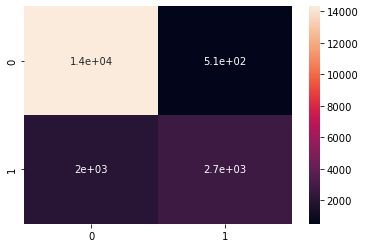

In [60]:
cf_matrix_train = confusion_matrix(target_train, best_random.predict(data_train))
print(cf_matrix_train)

sns.heatmap(cf_matrix_train, annot=True)

[[4729  211]
 [ 715  858]]


<AxesSubplot:>

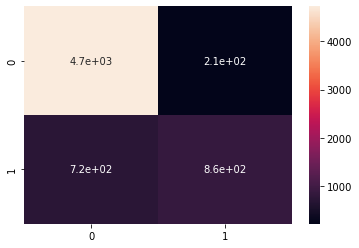

In [61]:
cf_matrix_test = confusion_matrix(target_test, best_random.predict(data_test))
print(cf_matrix_test)

sns.heatmap(cf_matrix_test, annot=True)